In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


Station observation counts:
 name
dha phase 5                                  52763
Korangi Sector 15                            51628
ayesha manzil                                25613
TDF MagnifiScience Centre                    19538
US Consulate in Karachi                      18287
Quaidabad                                    18066
Empress Market                               17585
dawood public school                         17546
cp & berar society, shaheed-e-millat road    15191
NED University                               14329
Hyderi                                       13858
Lakson Investments                            9552
Korangi Darussalam Society                    9210
Kerry Freight Pakistan Pvt Ltd                9167
Sher Shah                                     9123
Korangi Creek                                 6459
Orangi Town                                   4912
Karachi Port - Kemari                         4646
WWF-Pakistan Karachi Office                   3

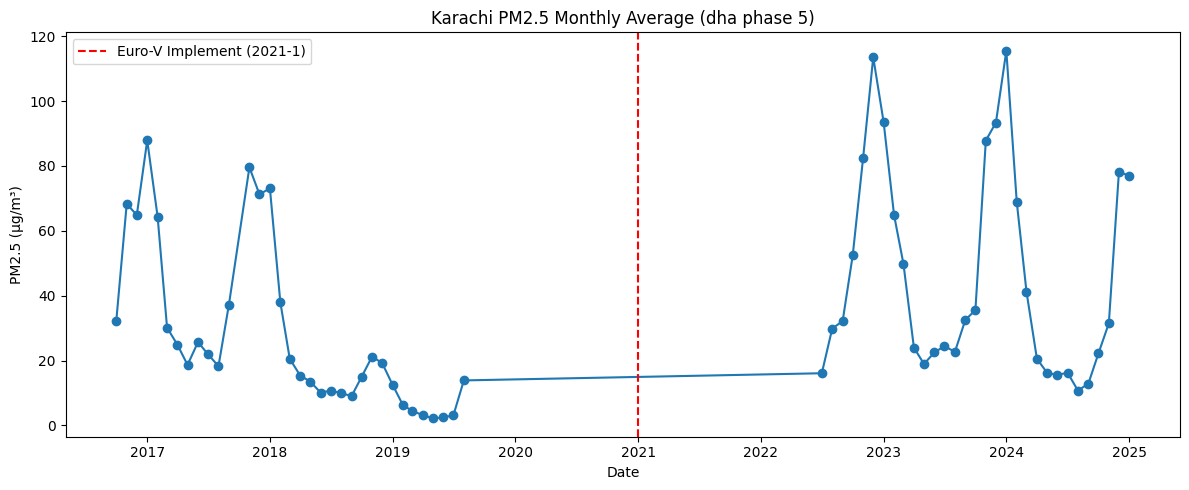

In [ ]:
# === LOAD DATA ===
df = pd.read_csv("C:/Users/Jinho Kim/Downloads/Pakistan Air Quality Initiative Data/PAQI_Karachi.csv")
#df = pd.read_csv("C:/Users/Jinho Kim/Downloads/PAQI_data_Karachi_2019-2025.csv")


# Normalize column names
df.columns = df.columns.str.strip().str.lower()

# Keep only Karachi
df = df[df['city'].str.lower() == "karachi"].copy()

# Parse datetime
df['datetime'] = pd.to_datetime(df['datetime (utc+5)'], errors='coerce')

# Drop rows without datetime
df = df.dropna(subset=['datetime'])

# === 1. Identify which "Name" (station) has the MOST data ===
station_counts = df['name'].value_counts()
print("\nStation observation counts:\n", station_counts)

best_station = station_counts.idxmax()
print("\nSelected station:", best_station)

# Filter to the best station
df = df[df['name'] == 'Korangi Sector 15'].copy()

# === 2. Build monthly PM2.5 ===
df['year_month'] = df['datetime'].dt.to_period('M')
df.loc[df["pm2.5 (μg/m3)"] < 0, "pm2.5 (μg/m3)"] = np.nan
#df.loc[df["pm2.5"] < 0, "pm2.5"] = np.nan

monthly = df.groupby('year_month')['pm2.5 (μg/m3)'].mean().reset_index()
#monthly = df.groupby('year_month')['pm2.5'].mean().reset_index()

monthly.rename(columns={'pm2.5 (μg/m3)': 'pm25'}, inplace=True)
#monthly.rename(columns={'pm2.5': 'pm25'}, inplace=True)

# Convert year_month to timestamp for plotting / merging later
monthly['date'] = monthly['year_month'].dt.to_timestamp()

print("\nFinal monthly dataset head:\n", monthly.head())
print("\nShape:", monthly.shape)

# === >>> SAVE KARACHI MONTHLY PM2.5 DATA <<< ===
#monthly[['date', 'pm25']].to_csv("karachi_2019-2025_monthly_pm25.csv", index=False)
#print("\nSaved: karachi_2019-2025_monthly_pm25.csv")

# === 3. Plot (optional) ===
plt.figure(figsize=(12,5))
plt.plot(monthly['date'], monthly['pm25'], marker='o')
plt.axvline(pd.Timestamp("2021-01-01"), color="red", linestyle="--", label="Euro-V Implement (2021-1)")
plt.title(f"Karachi PM2.5 Monthly Average ({best_station})")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Jinho Kim\AppData\Local\Temp\ipykernel_11348\3233765645.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date (LT)'], errors='coerce')


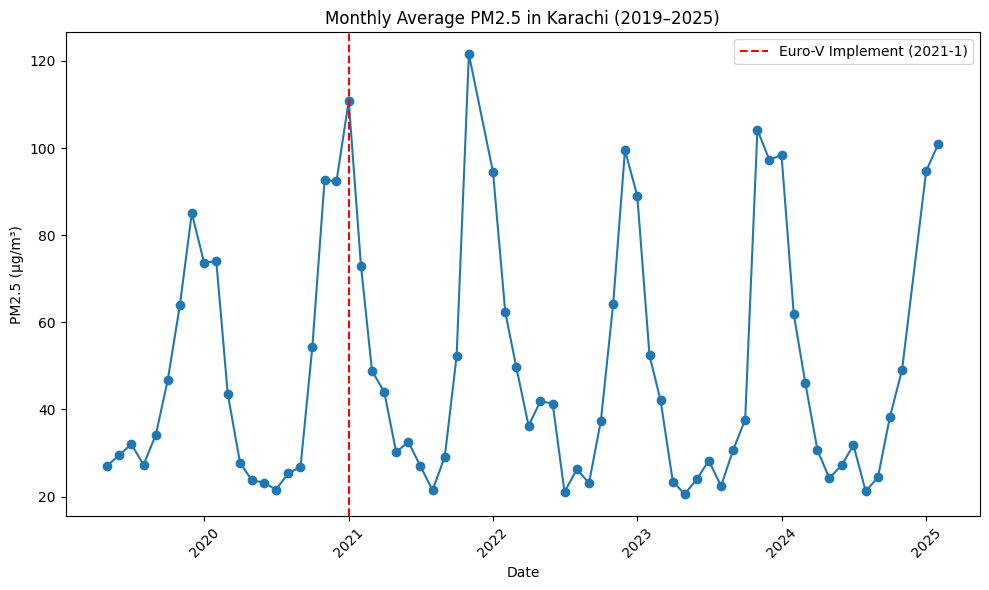


Saved: karachi_monthly_pm25.csv


In [ ]:
import glob
files = sorted(glob.glob("C:/Users/Jinho Kim/Downloads/pakistan/karachi/Karachi_PM2.5_*_YTD.csv"))
dfs=[]
for f in files:
    df=pd.read_csv(f)
    df['Date']=pd.to_datetime(df['Date (LT)'], errors='coerce')
    dfs.append(df)

data=pd.concat(dfs, ignore_index=True)
data = data[data["Raw Conc."] >= 0]

pm_col='Raw Conc.'

data['YearMonth']=data['Date'].dt.to_period('M')
monthly_avg=data.groupby('YearMonth')[pm_col].mean().reset_index()
monthly_avg['YearMonth']=monthly_avg['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(10,6))
plt.plot(monthly_avg['YearMonth'], monthly_avg[pm_col], marker='o')
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Monthly Average PM2.5 in Karachi (2019–2025)")
plt.axvline(pd.Timestamp("2021-01-01"), color="red", linestyle="--", label="Euro-V Implement (2021-1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

monthly_avg.head(), plt.show()

# === >>> SAVE KARACHI MONTHLY PM2.5 DATA <<< ===
monthly_avg[['YearMonth', 'Raw Conc.']].to_csv("karachi_monthly_pm25.csv", index=False)
print("\nSaved: karachi_monthly_pm25.csv")